In [1]:
%%capture
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import subprocess
import os

# Based on https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system
try:
    subprocess.check_output('nvidia-smi')
    print("a GPU is connected.")
except Exception:
    # TPU or CPU
    if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
      print("A TPU is connected.")
      import jax.tools.colab_tpu
      jax.tools.colab_tpu.setup_tpu()
    else:
      print("Only CPU accelerator is connected.")
      # x8 cpu devices - number of (emulated) host devices
      os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

!pip install optax
!pip install livelossplot
!pip install numpyro

import jax
import jax.numpy as jnp
from jax.numpy.linalg import inv
from jax import grad, jit, vmap, random, value_and_grad
from jax.scipy.stats import norm, bernoulli
from jax.nn import sigmoid, tanh
from jax.nn.initializers import normal
from jax.scipy.linalg import solve


import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

from functools import partial

import optax
from optax import sigmoid_binary_cross_entropy


from livelossplot import PlotLosses

In [4]:
# @title Helper Functions. (Run Cell)


import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )


def errorfill(
    x,
    y,
    yerr,
    color=None,
    alpha_fill=0.3,
    line_alpha=1,
    ax=None,
    lw=1,
    linestyle="-",
    fill_linewidths=0.2,
    marker=None,
    markersize=1,
    label=None,
    markevery=None,
):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(
        x,
        y,
        color=color,
        lw=lw,
        linestyle=linestyle,
        alpha=line_alpha,
        label=label,
        marker=marker,
        markersize=markersize,
        markevery=markevery,
    )
    ax.fill_between(
        x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths
    )
    return plt_return


def plot_basic_data(
    x_data, y_data, parameters_list=None, title="Observed data", ylim=None
):
    xlim = [jnp.min(x_data) - 1, jnp.max(x_data) + 1]

    if ylim is None:
        ylim = [jnp.min(y_data) - 1, jnp.max(y_data) + 1]
    fig, ax = plt.subplots()

    if parameters_list is not None:
        x_pred = np.linspace(xlim[0], xlim[1], 100)
        for parameters in parameters_list:
            y_pred = parameters[0] + parameters[1] * x_pred
            ax.plot(x_pred, y_pred, ":", color=[1, 0.7, 0.6])

        parameters = parameters_list[-1]
        y_pred = parameters[0] + parameters[1] * x_pred
        ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)

    ax.plot(x_data, y_data, "ob")
    ax.set(xlabel="Input x", ylabel="Output y", title=title, xlim=xlim, ylim=ylim)
    ax.grid()


def optimise(objective, params, plotting_func, LR, MAX_STEPS, LOG_EVERY):

    optimiser = optax.chain(optax.adam(LR, b1=0.99, b2=0.999))
    opt_state = optimiser.init(params)

    def gen_update(objective):
        def update(params, opt_state, key):
            # get data neded for training
            value, grads = jax.value_and_grad(objective)(params, key)
            grads = jax.tree_map(lambda x: -x, grads)
            updates, opt_state = optimiser.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            return value, params, opt_state

        return jit(update)

    update = gen_update(objective)

    plotlosses = PlotLosses()
    objective_values = []
    artist_list = []

    key = random.PRNGKey(42)
    keys = random.split(key, MAX_STEPS)
    # Training & evaluation loop.
    for step in range(MAX_STEPS):
        objective_value, params, opt_state = update(params, opt_state, keys[step])
        objective_values.append(objective_value)

        if step % LOG_EVERY == 0:
            # Plot objective curve
            objective_mean = jnp.array(objective_values).mean()
            plotlosses.update(
                {
                    "objective_value": objective_mean,
                }
            )
            plotlosses.send()
            objective_values = []

            # Plot loss landscape and variational distribution
            if plotting_func is not None:
                plotting_func(params)

    return params


def generate_loss_grid(loss_fun, grid_size, lim0, lim1):

    x0, x1 = np.linspace(lim0[0], lim0[1], num=grid_size), np.linspace(
        lim1[0], lim1[1], num=grid_size
    )
    x0_grid, x1_grid = np.meshgrid(x0, x1)

    param_mat = jnp.stack([x0_grid.ravel(), x1_grid.ravel()], axis=0)

    vmap_loss_fun = vmap(loss_fun)
    loss_grid = vmap_loss_fun(param_mat.T).reshape(grid_size, grid_size)
    return x0_grid, x1_grid, loss_grid


def plot_log_gaussian_ellipse(
    ax,
    mean,
    cov,
    color="b",
    alpha=1,
    lw=1,
    label=None,
    MAP_size=5,
    std_levels=[1, 2, 4, 6],
):

    eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
    theta = np.linspace(0, 2 * np.pi, 1200)
    std_ellipsis = (np.sqrt(eigenvalues[None, :]) * eigenvectors) @ jnp.stack(
        [np.sin(theta), np.cos(theta)]
    )

    artists = []

    for level in std_levels:
        artists.append(
            ax.plot(
                mean[0] + level * std_ellipsis[0, :],
                mean[1] + level * std_ellipsis[1, :],
                c=color,
                alpha=alpha,
                lw=lw,
            )
        )

    artists.append(
        ax.scatter(
            [mean[0]],
            [mean[1]],
            MAP_size,
            color=color,
            label=label,
            alpha=alpha,
            marker="x",
        )
    )

    return artists

In [3]:
# @title Check the device you are using (Run Cell)
#Just CPU is fine!
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")


Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# Bayesian learning machine!
#Standard Linear Regression

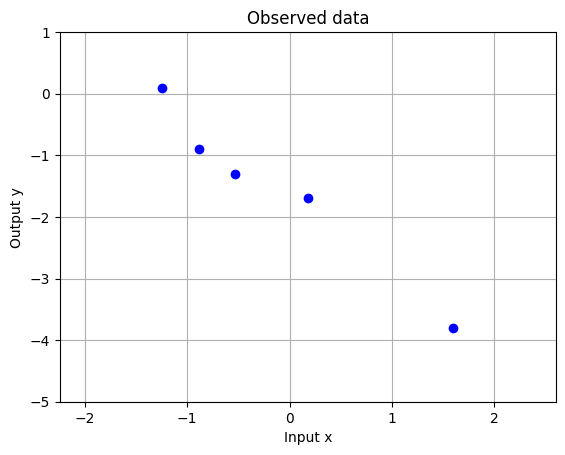

In [6]:
# @title First dataset
#Let's build a simple dataset, with 6 pairs.

x_data_list_outlier = jnp.array([1, 1.5, 2, 3, 4, 5])
x_data_list_outlier = (
    x_data_list_outlier - x_data_list_outlier.mean()
) / x_data_list_outlier.std()  #
y_data_list_outlier = jnp.array([3.1, 2.1, 1.7, 1.3, -5, -0.8]) - 3

plot_basic_data(x_data_list_outlier, y_data_list_outlier, ylim=[-5, 1])

In [7]:
#Finding plausible solutions manually
parameters_list = []  # Used to track which parameters were tried.

Plotting line -1.21 * x + -1.9


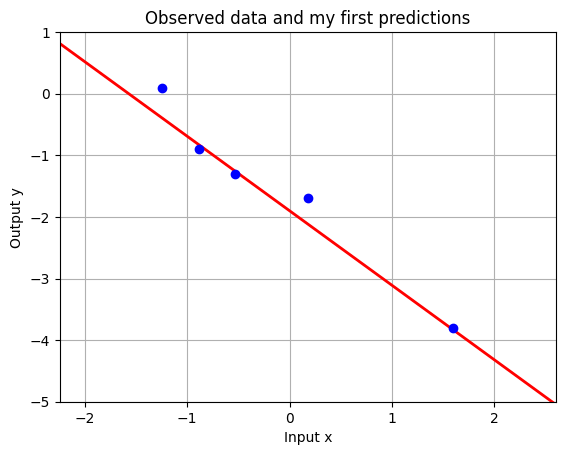

In [8]:
# @title  { run: "auto" }
b = -1.9  # @param {type:"slider", min:-5, max:5, step:0.01}
w = -1.21  # @param {type:"slider", min:-5, max:5, step:0.01}
print("Plotting line", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
plot_basic_data(
    x_data_list_outlier,
    y_data_list_outlier,
    parameters_list,
    title="Observed data and my first predictions",
    ylim=[-5, 1],
)

In [9]:
manual_parameters_list = jnp.array(
    parameters_list
)  # turn your chosen parameter values into a jnp array


# **Introducing matrix notation!**

In [20]:
# @title Answer  (Try not to peek until you've given it a good try!')


def affine_basis(x):
    """
    Maps a vector of inputs [x_0, x_1, ...]
    onto the affine basis [[1, x_0], [1, x_1], [1, x_2], ...]

    Args:
      x: jnp array of shape (N,) or (N,1)
    Returns:
      X: jnp array of shape (N,2)
    """
    if x.ndim == 1:
        x = x.copy()[:, None]

    pad_ones = jnp.ones(
        (len(x), 1)
    )  # the bias can be interpreted as a weight that multiplies an input with a constant value of 1
    X = jnp.concatenate([pad_ones, x], axis=1)
    return X


In [21]:
# @title Run me to test your code


X = affine_basis(x_data_list_outlier)

X_correct = jnp.stack([jnp.ones(len(x_data_list_outlier)), x_data_list_outlier], axis=1)

assert jnp.allclose(X_correct, X), "X is not calculated correctly"

print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


In [23]:
# @title Now we implement the linear function
# it will take a single point as input and then we will vmap it to deal with batches of inputs


def linear(x, w):
    return x @ w


vmap_linear = jit(vmap(linear, in_axes=(0, None)))

In [25]:
def linear_regression_loss(X, y, vmap_model, w):
    """
    Computes SE loss

    Args:
      X: jnp array of shape (N,2)
      y: jnp array of shape (N,)
      w: jnp array of shape (w,)
      vmap_model: function that maps (X, w) onto y
    Returns:
      squared_error: scalar
    """
    predictions = vmap_model(X, w)
    squared_error = 0.5 * ((y - predictions) ** 2).sum()
    return squared_error

In [26]:
# @title Run me to test your code


mse = linear_regression_loss(
    affine_basis(x_data_list_outlier),
    y_data_list_outlier,
    vmap_linear,
    jnp.array([2, 2]),
)

mse_correct = (
    0.5
    * (
        (
            vmap_linear(affine_basis(x_data_list_outlier), jnp.array([2, 2]))
            - y_data_list_outlier
        )
        ** 2
    ).sum()
)

assert jnp.allclose(mse_correct, mse), "X is not calculated correctly"

print("It seems correct. Look at the answer below to compare methods.")

It seems correct. Look at the answer below to compare methods.


In [27]:
# @title Answer  (Try not to peek until you've given it a good try!')


def linear_regression_loss(X, y, vmap_model, w):
    """
    Computes MSE loss

    Args:
      X: jnp array of shape (N,2)
      y: jnp array of shape (N,)
      w: jnp array of shape (w,)
      vmap_model: function that maps (X, w) onto y
    Returns:
      squared_error: scalar
    """
    predictions = vmap_model(X, w)
    squared_error = 0.5 * ((y - predictions) ** 2).sum()
    return squared_error

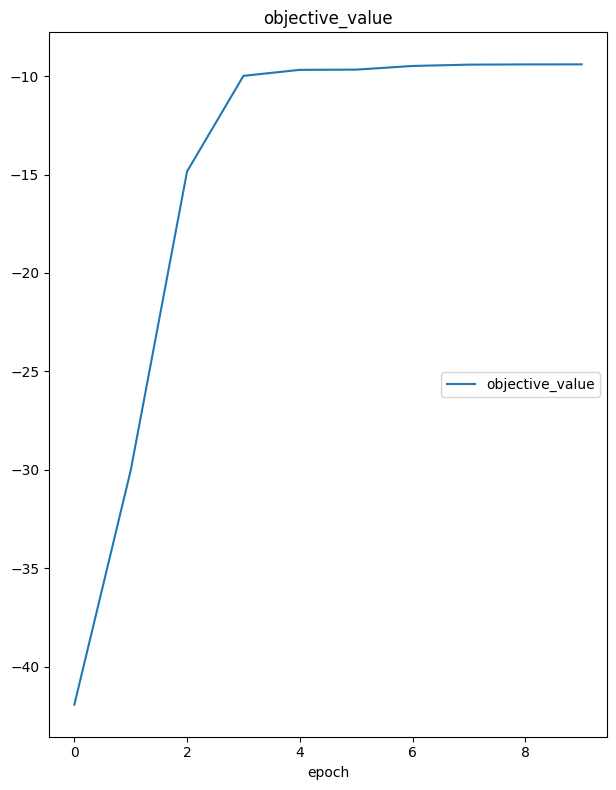

objective_value
	objective_value  	 (min:  -41.920, max:   -9.406, cur:   -9.406)
Your optimised parameter values are [-2.6085892 -2.0239995]


In [28]:
# @title Lets optimise our parameters with the squared error loss
# Note that in this prac we will be working with objectives which are the inverse of the loss. That means that it is good if the training curve goes up!


def gen_objective(X, y, vmap_model):
    def objective(params, key):
        return -linear_regression_loss(X, y, vmap_model, params)

    return objective


objective = gen_objective(
    affine_basis(x_data_list_outlier), y_data_list_outlier, vmap_linear
)

optimised_params = optimise(
    objective,
    params=jnp.array([0.0, 0.0]),
    plotting_func=None,
    LR=1e-2,
    MAX_STEPS=1000,
    LOG_EVERY=100,
)

print("Your optimised parameter values are", optimised_params)

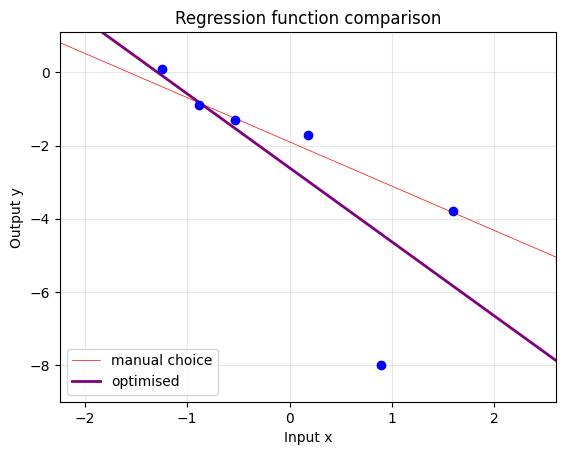

In [29]:
# @title Lets look at how your manually chosen regression functions compare with the optimised one


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier) - 1, jnp.max(x_data_list_outlier) + 1]
ylim = [jnp.min(y_data_list_outlier) - 1, jnp.max(y_data_list_outlier) + 1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

ax = plt.gca()

ax.plot(
    x_test,
    vmap_linear(X_test, manual_parameters_list.T),
    c="red",
    lw=0.5,
    label="manual choice",
)
ax.plot(
    x_test, vmap_linear(X_test, optimised_params), c="purple", lw=2, label="optimised"
)

ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.set_title("Regression function comparison")
ax.legend(loc="lower left")

In [30]:
#  Our *regularised* loss is
#  where is the regularisation strength.


def regularised_linear_regression_loss(X, y, vmap_model, w, alpha):
    predictions = vmap_model(X, w)
    data_fit = 0.5 * ((y - predictions) ** 2).sum()
    regulariser = 0.5 * alpha * (w**2).sum()
    return data_fit + regulariser

In [31]:
#  What is the solution? (Options given already in code)

# Hint: `inv(A)`  computes A^{-1} and `solve(A,B)` computes A^{-1} B

selection = "X.T @ X + alpha * jnp.eye(w.shape[0])"  #  ['X.T @ X + alpha * jnp.eye(w.shape[0])', "solve(X.T @ X + alpha * jnp.eye(X.shape[1]), X.T @ y)", "inv(X.T @ X) @ (\alpha + X.T @ y)"]
print(f"You selected: {selection}")

You selected: X.T @ X + alpha * jnp.eye(w.shape[0])


In [32]:
# @title Coding task (Optional): choose one of the 3 options from above


def regularised_least_squares_solution(X, y, alpha):
    return  # paste solution here

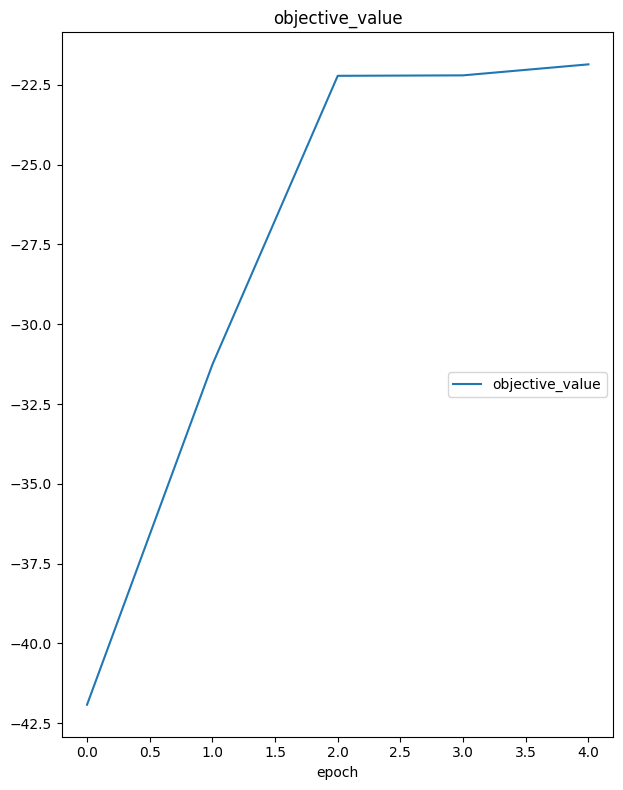

objective_value
	objective_value  	 (min:  -41.920, max:  -21.856, cur:  -21.856)


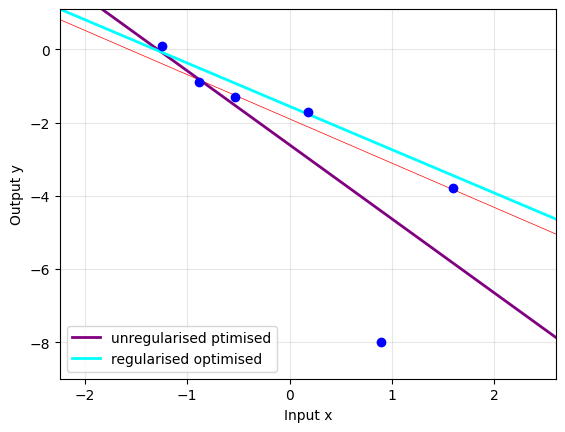

In [35]:
# @title Lets optimise the parameters with the regulariser and lets look at how the manually chosen regression functions compare with the regularised and unregularised ones `Base` {run: "auto"}

# @markdown **This does not require solving the optional task above**.

# @markdown Lets start with


# @markdown Play around with different values to find the one that gives solutions that "feel" the best

alpha = 3.58  # @param {type:"slider", min:0, max:20, step:0.01}


def gen_objective(X, y, vmap_model, alpha):
    def objective(params, key):
        return -regularised_linear_regression_loss(X, y, vmap_model, params, alpha)

    return objective


objective = gen_objective(
    affine_basis(x_data_list_outlier), y_data_list_outlier, vmap_linear, alpha
)

optimised_regularised_params = optimise(
    objective,
    params=jnp.array([0.0, 0.0]),
    plotting_func=None,
    LR=1e-2,
    MAX_STEPS=500,
    LOG_EVERY=100,
)


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier) - 1, jnp.max(x_data_list_outlier) + 1]
ylim = [jnp.min(y_data_list_outlier) - 1, jnp.max(y_data_list_outlier) + 1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

ax = plt.gca()

ax.plot(x_test, vmap_linear(X_test, manual_parameters_list.T), c="red", lw=0.5)
ax.plot(
    x_test,
    vmap_linear(X_test, optimised_params),
    c="purple",
    lw=2,
    label="unregularised ptimised",
)
ax.plot(
    x_test,
    vmap_linear(X_test, optimised_regularised_params),
    c="cyan",
    lw=2,
    label="regularised optimised",
)

ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend(loc="lower left")

In [36]:
# @title (Optional) If you coded the exact solution, lets compare it with the output of the optimiser
# @markdown Note that both parameter vectors will not be exactly the same due to our optimisation not having fully converged.

# Hint: the correct solution to the above question was (b)
exact_regularised_params = regularised_least_squares_solution(
    affine_basis(x_data_list_outlier), y_data_list_outlier, alpha
)

print("Your regularised optimised parameter values are", optimised_regularised_params)
print("Your regularised exact parameter values are", exact_regularised_params)


Your regularised optimised parameter values are [-1.5565733 -1.1843921]
Your regularised exact parameter values are None


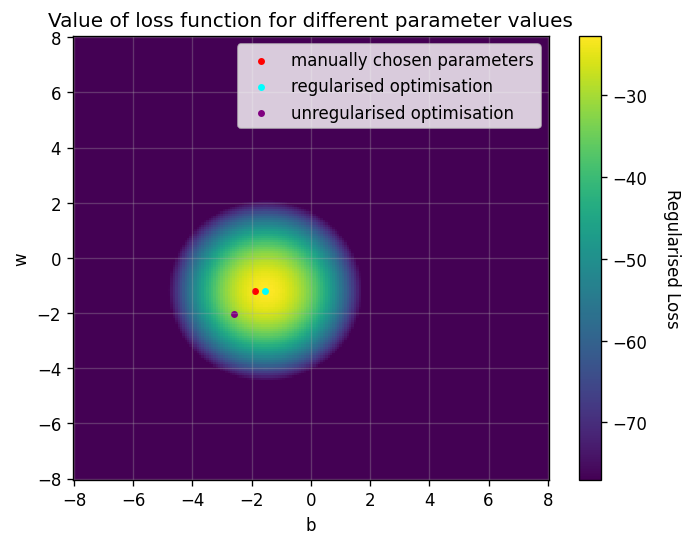

In [38]:
# @title  { run: "auto" }
# @markdown Lets plot the loss for a large grid of
#and values to see which ones would work well

# @markdown Try different values of alpha to see how they affect the loss landscape


alpha = 4.18  # @param {type:"slider", min:0, max:20, step:0.01}


def generate_loss_fun():
    def loss_fun(w):
        return regularised_linear_regression_loss(
            X=affine_basis(x_data_list_outlier),
            y=y_data_list_outlier,
            w=w,
            vmap_model=vmap_linear,
            alpha=alpha,
        )

    return loss_fun


loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(
    loss_fun=loss_fun, grid_size=200, lim0=[-8, 8], lim1=[-8, 8]
)


plt.figure(dpi=120)
plt.pcolormesh(
    x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min(), vmax=-70, cmap="viridis"
)  #
plt.ylabel("w")
plt.xlabel("b")
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label("Regularised Loss", rotation=270, labelpad=20)

plt.scatter(
    manual_parameters_list[:, 0],
    manual_parameters_list[:, 1],
    10,
    color="red",
    label="manually chosen parameters",
)
plt.scatter(
    optimised_regularised_params[0],
    optimised_regularised_params[1],
    10,
    color="cyan",
    label="regularised optimisation",
)
plt.scatter(
    optimised_params[0],
    optimised_params[1],
    10,
    color="purple",
    label="unregularised optimisation",
)
plt.title("Value of loss function for different parameter values")
plt.legend()

In [41]:
#@title **coding task** `base` : implement a method that computes the posterior distribution for linear regression
def BLR_posterior(X, y, alpha):
    """
    Computes linear regression posterior parameters

    Args:
      X: jnp array of shape (N,D)
      y: jnp array of shape (N,)
      alpha: scalar - regulasisation strength
    Returns:
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    """
    D = X.shape[1] # D=2 parameters, one weight and 1 bias
    precision = X.T @ X + alpha * jnp.eye(D)
    covariance = jnp.linalg.inv(precision)
    mu = solve(precision, (X.T @ y))
    return mu, covariance

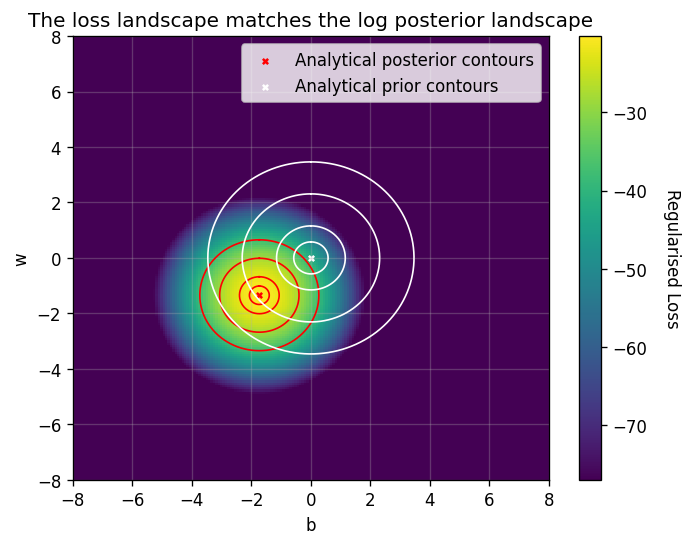

In [43]:
# @title We can plot our log posterior distribution by plotting our loss landscape, since both are equal up to a constant. {run : 'auto'}

#  **Plotting task** `Base`: Try different values of
 #to see how the prior and posterior change

#  Note: the concentric lines in the plot, also known as level-sets or contours, allow us to see how fast the value of a function decreases. If the contours are very close to each other, it means that the function decreases fast.

alpha = 3  # @param {type:"slider", min:0.01, max:20, step:0.01
mu, covariance = BLR_posterior(
    affine_basis(x_data_list_outlier), y_data_list_outlier, alpha
)


def generate_loss_fun():
    def loss_fun(w):
        return regularised_linear_regression_loss(
            X=affine_basis(x_data_list_outlier),
            y=y_data_list_outlier,
            w=w,
            vmap_model=vmap_linear,
            alpha=alpha,
        )

    return loss_fun


loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(
    loss_fun=loss_fun, grid_size=200, lim0=[-8, 8], lim1=[-8, 8]
)


plt.figure(dpi=120)
plt.pcolormesh(
    x0_grid, x1_grid, -loss_grid, vmin=-loss_grid.min(), vmax=-70, cmap="viridis"
)  #
plt.ylabel("w")
plt.xlabel("b")
plt.grid(alpha=0.3)
cbar = plt.colorbar()
cbar.set_label("Regularised Loss", rotation=270, labelpad=20)

ax = plt.gca()
plot_log_gaussian_ellipse(
    ax=ax,
    mean=mu,
    cov=covariance,
    color="r",
    alpha=1,
    lw=1,
    label="Analytical posterior contours",
    MAP_size=10,
    std_levels=[1, 2, 4, 6],
)
plot_log_gaussian_ellipse(
    ax=ax,
    mean=jnp.array([0, 0.0]),
    cov=(alpha**-1) * jnp.eye(2),
    color="w",
    alpha=1,
    lw=1,
    label="Analytical prior contours",
    MAP_size=10,
    std_levels=[1, 2, 4, 6],
)
plt.title("The loss landscape matches the log posterior landscape")
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.legend()

In [45]:
# @title Exact predictive posterior for Bayesian Linear regression

#  Here is the code to implement this.

#  Instead of returning the full covariance, we will return the square root of the diagonal
#This is the predictive standard deviation. The std dev is nice for plotting because its scale matches that of the data.


def BLR_predictions(X, mu, covariance):
    """
    Computes linear regression posterior predictive distribution.
    Instead of returning the full covariance we will return the square root of the diagonal. This is the predictive standard deviation, which is nice for plotting.

    Args:
      X: jnp array of shape (N,D)
      mu: jnp array of shape (D,)
      covariance: jnp array of shape (D,D)
    Returns:
      predictive_mean: jnp array of shape (N,)
      predictive_std: jnp array of shape (N,)
    """
    predictive_mean = X @ mu
    predictive_std = jnp.diag(X @ covariance @ X.T) ** 0.5
    return predictive_mean, predictive_std

Text(0.5, 1.0, 'predictive mean + 1 standard deviation errorbars on either side')

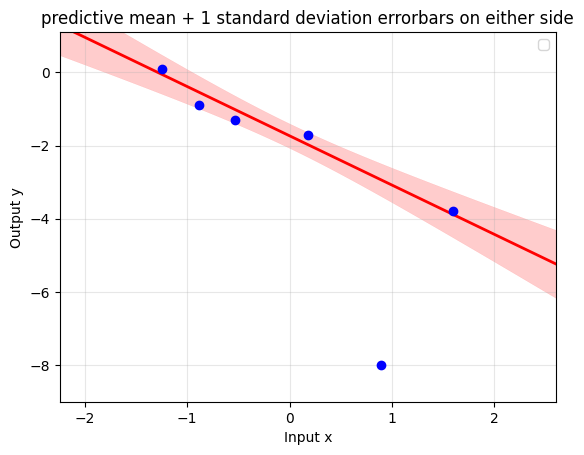

In [47]:
# @title **Plotting task** `Base`: Lets look at the posterior predictive distribution for different values of
 #{run : 'auto'}

alpha = 3.0  # @param {type:"slider", min:0.01, max:20, step:0.01
mu, covariance = BLR_posterior(
    affine_basis(x_data_list_outlier), y_data_list_outlier, alpha
)


plt.figure(dpi=100)

xlim = [jnp.min(x_data_list_outlier) - 1, jnp.max(x_data_list_outlier) + 1]
ylim = [jnp.min(y_data_list_outlier) - 1, jnp.max(y_data_list_outlier) + 1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

predictive_mean, predictive_std = BLR_predictions(X_test, mu, covariance)

ax = plt.gca()
errorfill(
    x_test,
    predictive_mean,
    predictive_std,
    color="red",
    alpha_fill=0.2,
    line_alpha=1,
    ax=ax,
    lw=2,
    linestyle="-",
    fill_linewidths=0.2,
    marker=None,
    markersize=1,
    label=None,
    markevery=None,
)


ax.plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax.set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
ax.grid(alpha=0.3)
ax.legend()
plt.title("predictive mean + 1 standard deviation errorbars on either side")

In [48]:
key = random.PRNGKey(0)
Nsamples = 10

parameter_samples = jax.random.multivariate_normal(
    key, mu, covariance, shape=(Nsamples,)
)
sample_preds = vmap_linear(X_test, parameter_samples.T)
MC_mean = sample_preds.mean(axis=1)
MC_std = sample_preds.std(axis=1)

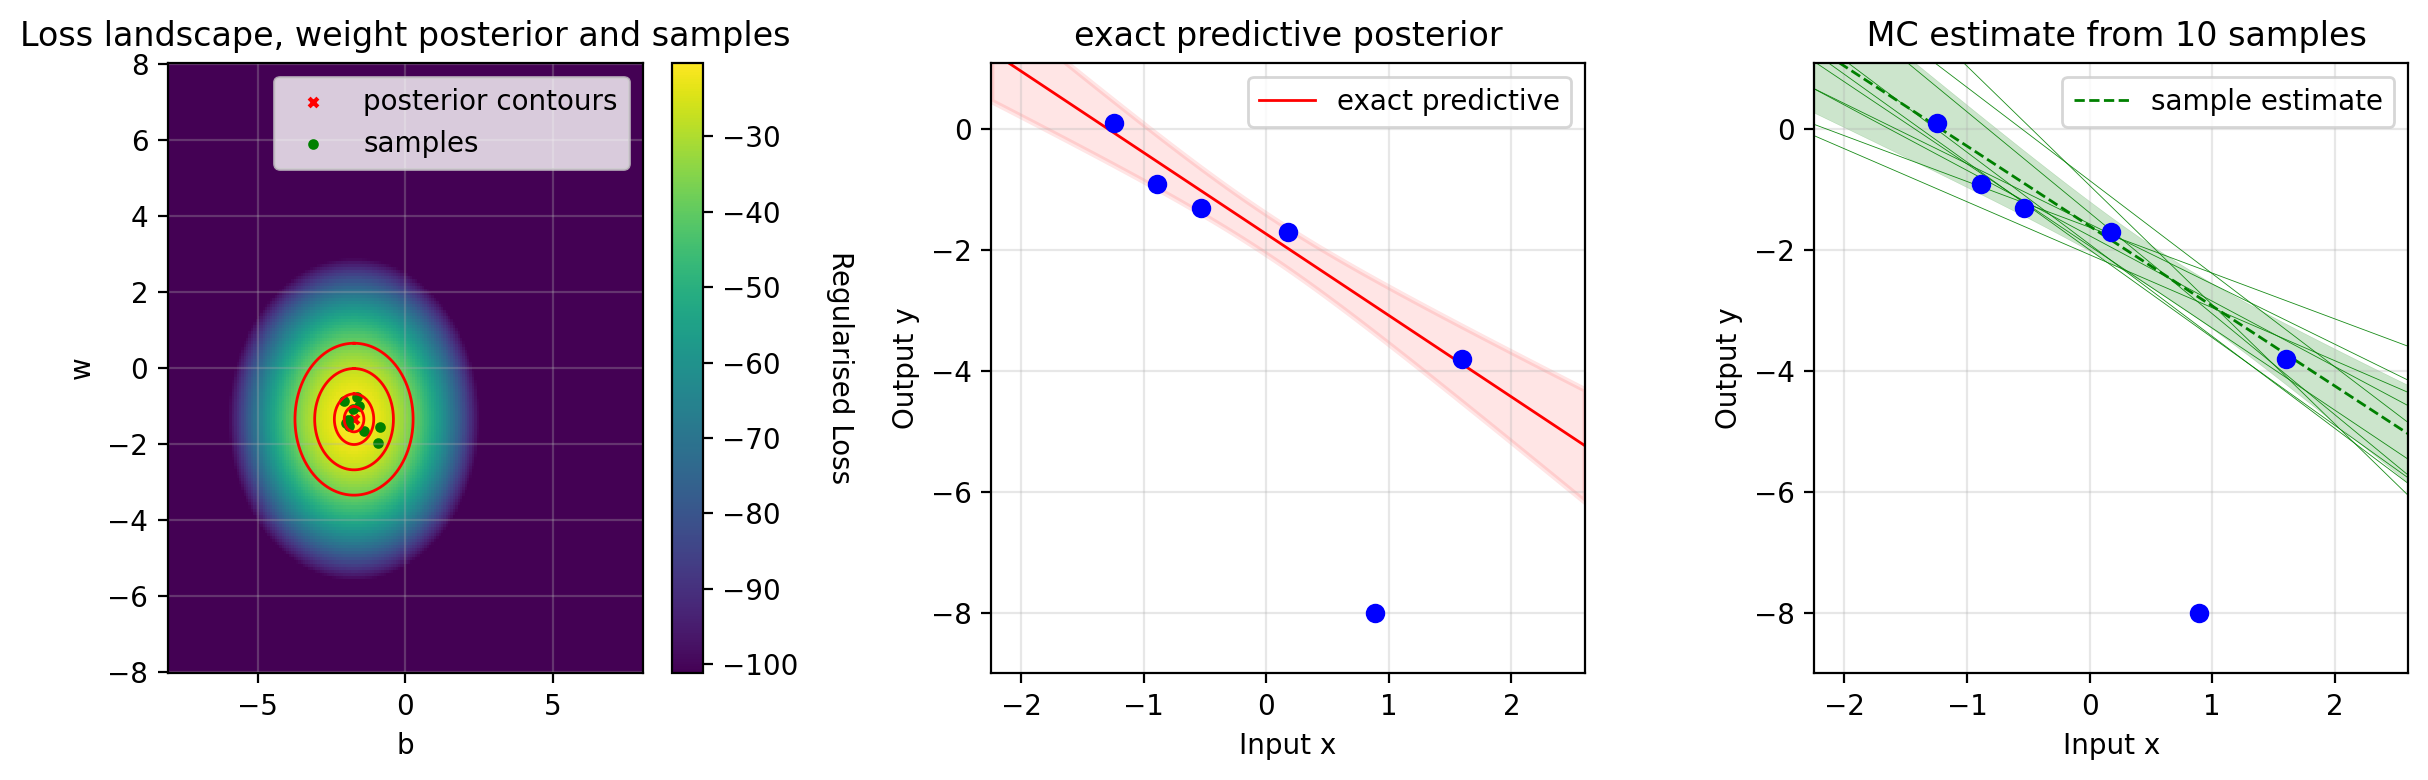

In [49]:
# @title visualizing the Monte Carlo estimate of the predictive posterior

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 4))


loss_landscape = ax[0].pcolormesh(
    x0_grid,
    x1_grid,
    -loss_grid,
    vmin=-loss_grid.min() * 5,
    vmax=-loss_grid.min(),
    cmap="viridis",
)  #
ax[0].set_ylabel("w")
ax[0].set_xlabel("b")
ax[0].grid(alpha=0.3)
ax[0].set_title("Loss landscape, weight posterior and samples")

plot_log_gaussian_ellipse(
    ax=ax[0],
    mean=mu,
    cov=covariance,
    color="r",
    alpha=1,
    lw=1,
    label="posterior contours",
    MAP_size=10,
    std_levels=[1, 2, 4, 6],
)

ax[0].scatter(
    parameter_samples[:, 0], parameter_samples[:, 1], 8, color="green", label="samples"
)
cbar = fig.colorbar(loss_landscape, ax=ax[0])
cbar.set_label("Regularised Loss", rotation=270, labelpad=20)
ax[0].legend()


xlim = [jnp.min(x_data_list_outlier) - 1, jnp.max(x_data_list_outlier) + 1]
ylim = [jnp.min(y_data_list_outlier) - 1, jnp.max(y_data_list_outlier) + 1]

x_test = jnp.linspace(xlim[0], xlim[1], 201)
X_test = affine_basis(x_test)

errorfill(
    x_test,
    predictive_mean,
    predictive_std,
    color="red",
    alpha_fill=0.1,
    line_alpha=1,
    ax=ax[1],
    lw=1,
    linestyle="-",
    fill_linewidths=2,
    marker=None,
    markersize=1,
    label="exact predictive",
    markevery=None,
)


ax[1].plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax[1].set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
ax[1].grid(alpha=0.3)
ax[1].legend()
ax[1].set_title(f"exact predictive posterior")

ax[2].plot(x_test, sample_preds, "-", color="green", lw=0.3, alpha=0.9)
errorfill(
    x_test,
    MC_mean,
    MC_std,
    color="green",
    alpha_fill=0.2,
    line_alpha=1,
    ax=ax[2],
    lw=1,
    linestyle="--",
    fill_linewidths=0.2,
    marker=None,
    markersize=1,
    label="sample estimate",
    markevery=None,
)


ax[2].plot(x_data_list_outlier, y_data_list_outlier, "ob")
ax[2].set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
ax[2].grid(alpha=0.3)
ax[2].legend()
ax[2].set_title(f" MC estimate from {Nsamples} samples")


plt.tight_layout()

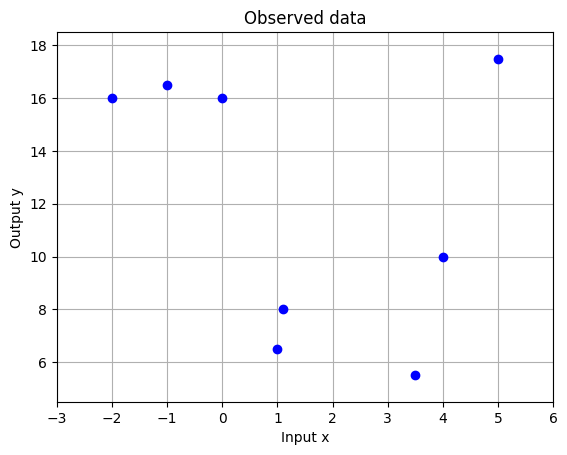

In [50]:
# @markdown Lets introduce a dataset that requires a non-linear model.
x_data_list_nonlinear = jnp.array([-2, -1, 0, 1, 1.1, 3.5, 4, 5])
y_data_list_nonlinear = jnp.array([3.2, 3.3, 3.2, 1.3, 1.6, 1.1, 2.0, 3.5]) * 5

plot_basic_data(x_data_list_nonlinear, y_data_list_nonlinear)

In [51]:
def generate_cosine_basis(key, N_inputs, N_elements, s_std=1):

    key, _ = random.split(key)
    S = random.normal(key, shape=(N_inputs, N_elements)) * s_std
    key, _ = random.split(key)
    u = (random.uniform(key, shape=(N_elements,)) - 0.5) * 2 * jnp.pi

    def basis_expand(x):
        if x.ndim == 1:
            x = x.copy()[:, None]
        return jnp.cos(x @ S + u) / np.sqrt(N_elements)

    return basis_expand


In [52]:
alpha = 0.001
std_s = 0.75

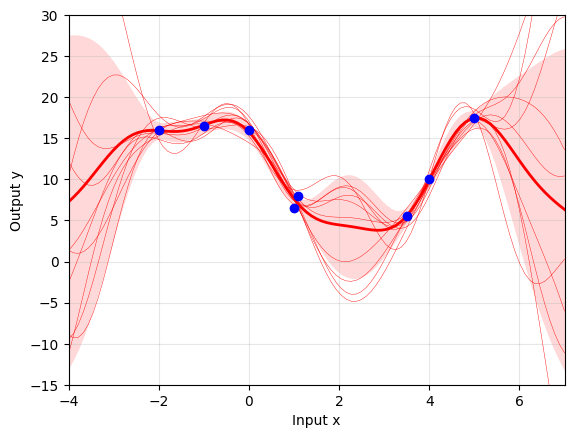

In [53]:
# @title Run regression using the code from this section but with the affine basis

# @markdown As before, the thick red line is the predictive mean, the transparent bars represent the standard deviation. The lin lines represent posterior samples.

N_inputs = 1
N_elements = 500

key = random.PRNGKey(42)


def gen_plots(params):

    xlim = [-4, 7]

    alpha = params[1]
    fourier_basis = generate_cosine_basis(key, N_inputs, N_elements, s_std=params[0])

    X = fourier_basis(x_data_list_nonlinear)
    mu, covariance = BLR_posterior(X, y_data_list_nonlinear, alpha)

    x_pred = jnp.linspace(xlim[0], xlim[1], 101)
    X_pred = fourier_basis(x_pred)

    parameter_samples = jax.random.multivariate_normal(
        key, mu, covariance, shape=(Nsamples,)
    )
    sample_preds = vmap_linear(X_pred, parameter_samples.T)

    predictive_mean, predictive_std = BLR_predictions(X_pred, mu, covariance)

    #################

    fig, ax = plt.subplots()
    ylim = [-15, 30]
    ax.plot(x_pred, sample_preds, "-", color="red", lw=0.3)

    errorfill(
        x_pred,
        predictive_mean,
        predictive_std,
        color="red",
        alpha_fill=0.15,
        line_alpha=1,
        ax=ax,
        lw=2,
        linestyle="-",
        fill_linewidths=0.2,
        marker=None,
        markersize=1,
        label=None,
        markevery=None,
    )

    ax.plot(x_data_list_nonlinear, y_data_list_nonlinear, "ob")
    ax.set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
    ax.grid(alpha=0.3)


gen_plots([std_s, alpha])

In [54]:
def linear_evidence(x_data_list, y_data_list, basis, alpha):
    X = basis(x_data_list)
    mu, covariance = BLR_posterior(X, y_data_list, alpha)
    loss = regularised_linear_regression_loss(
        X=X, y=y_data_list, w=mu, vmap_model=vmap_linear, alpha=alpha
    )
    a, log_det = jnp.linalg.slogdet(covariance)
    return (
        -loss
        + 0.5 * (len(mu) * jnp.log(alpha) + log_det)
        - 0.5 * len(x_data_list) * jnp.log(2 * jnp.pi)
    )

In [55]:
# @markdown Lets compute the evidence of our affine model and random fourier model on the new non-linear data

alpha = 0.01
s_std = 0.75
fourier_basis = generate_cosine_basis(key, N_inputs, N_elements, s_std)
fourier_evidence = linear_evidence(
    x_data_list_nonlinear, y_data_list_nonlinear, fourier_basis, alpha
)
affine_evidence = linear_evidence(
    x_data_list_nonlinear, y_data_list_nonlinear, affine_basis, alpha
)
print("fourier_evidence", fourier_evidence)
print("affine_evidence", affine_evidence)

fourier_evidence -27.609333
affine_evidence -95.67348


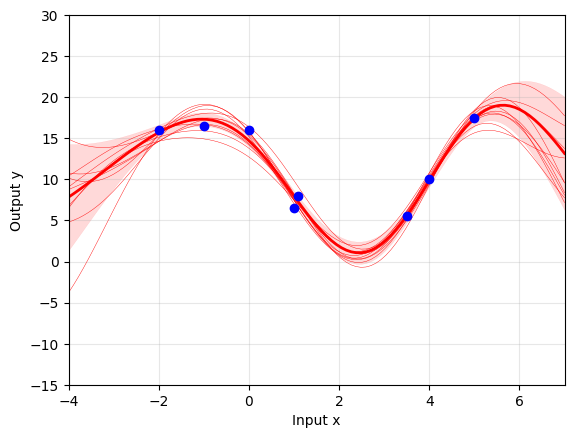

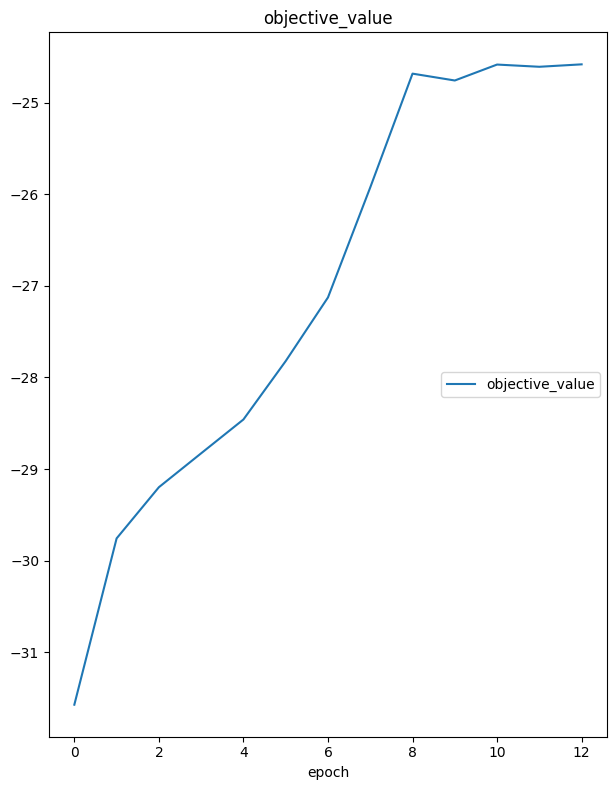

objective_value
	objective_value  	 (min:  -31.574, max:  -24.581, cur:  -24.581)


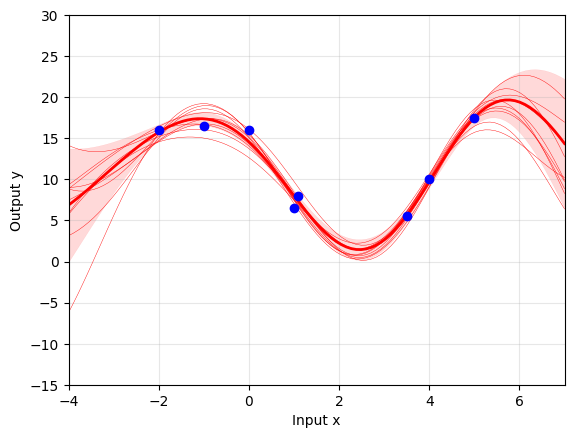

In [57]:
# @title **Plotting Task** (Optional) `Advanced`: Optimise the fourier basis standard deviation
 #and the regularisation strength
 #with the linear evidence objective


def gen_objective(x_data_list, y_data_list, key, N_elements):
    def objective(params, key):
        basis = generate_cosine_basis(key, 1, N_elements, s_std=params[0])
        return linear_evidence(x_data_list, y_data_list, basis, params[1])

    return objective


N_elements = 300
objective = gen_objective(x_data_list_nonlinear, y_data_list_nonlinear, key, N_elements)

optimised_regularised_classification_params = optimise(
    objective,
    params=jnp.array([2, 0.001]),
    plotting_func=gen_plots,
    LR=2e-3,
    MAX_STEPS=1300,
    LOG_EVERY=100,
)


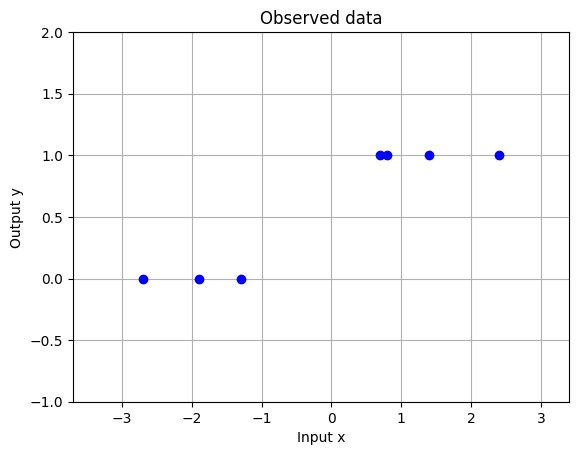

In [58]:
# @title Dataset for logistic regression.
# @markdown the task will be to classify points with the labels 0 or 1

x_data_list_classification = jnp.array([-2.7, -1.9, -1.3, 0.7, 0.8, 1.4, 2.4])
y_data_list_classification = jnp.array([0, 0, 0, 1, 1, 1, 1])


plot_basic_data(x_data_list_classification, y_data_list_classification)

In [59]:
# @title Define the model, same as above but with sigmoid


def logistic(w, x):
    return sigmoid(linear(w, x))


vmap_logistic = jit(vmap(logistic, in_axes=(None, 0)))


In [60]:
# @title Implementation of regularised cross entropy loss
# @markdown nottice that we do not code the sigmoid since it is implicit in the `sigmoid_binary_cross_entropy` method

# @markdown combining sigmoid and cross entropy in this way provides increased numerical stability


def logistic_regression_loss(X, y, vmap_model, w, alpha):
    data_fit_loss = sigmoid_binary_cross_entropy(vmap_model(X, w), y).sum(
        axis=0
    )  # optax loss has sigmoid integrated so we just use linear model
    parameter_norm = 0.5 * alpha * (w**2).sum()
    return data_fit_loss + parameter_norm

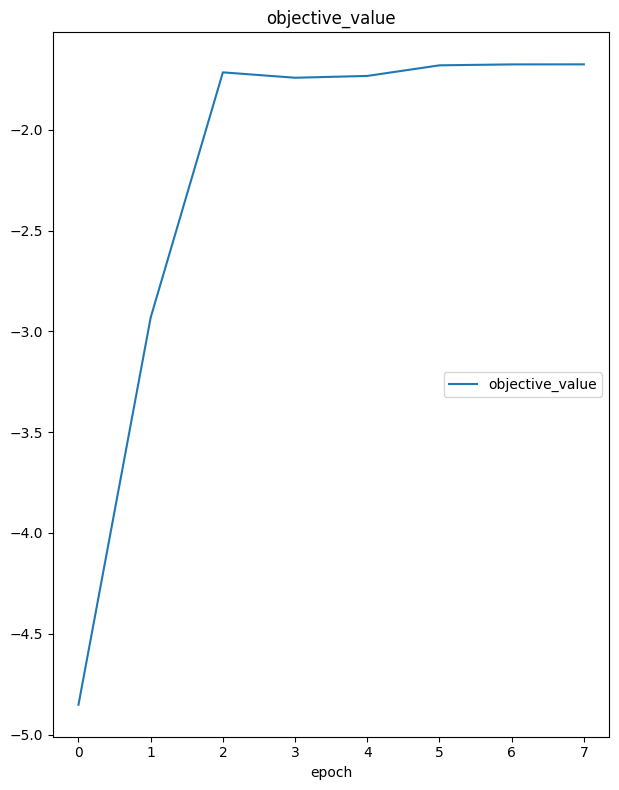

objective_value
	objective_value  	 (min:   -4.852, max:   -1.675, cur:   -1.675)


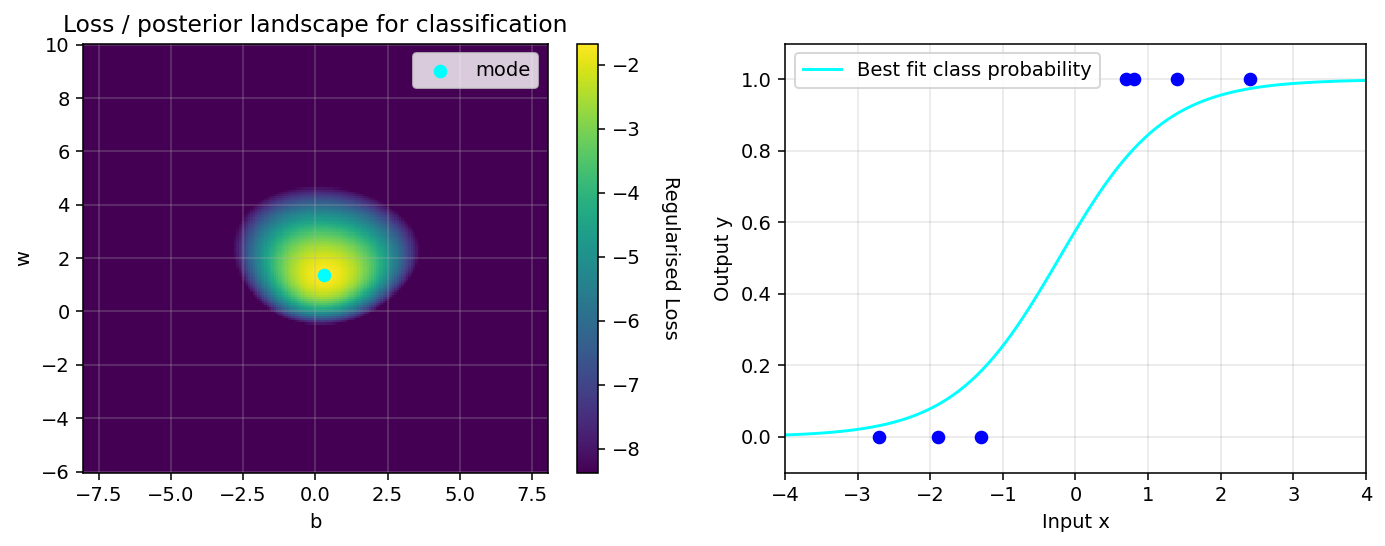

In [61]:
# @title Plotting the loss landscape and finding the solution at the mode
# @markdown Nottice that the loss is non-symmetric around its mode

alpha = 0.75


def generate_loss_fun():
    def loss_fun(w):
        return logistic_regression_loss(
            X=affine_basis(x_data_list_classification),
            y=y_data_list_classification,
            vmap_model=vmap_linear,
            w=w,
            alpha=alpha,
        )

    return loss_fun


loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(
    loss_fun=loss_fun, grid_size=200, lim0=[-8, 8], lim1=[-6, 10]
)


def gen_objective(X, y, vmap_model, alpha):
    def objective(params, key):
        return -logistic_regression_loss(X, y, vmap_model, params, alpha)

    return objective


objective = gen_objective(
    affine_basis(x_data_list_classification),
    y_data_list_classification,
    vmap_linear,
    alpha,
)

optimised_regularised_classification_params = optimise(
    objective,
    params=jnp.array([0.0, 0.0]),
    plotting_func=None,
    LR=1e-2,
    MAX_STEPS=800,
    LOG_EVERY=100,
)


fig, ax = plt.subplots(1, 2, dpi=140, figsize=(10, 4))
mesh = ax[0].pcolormesh(
    x0_grid,
    x1_grid,
    -loss_grid,
    vmin=-loss_grid.min() * 5,
    vmax=-loss_grid.min(),
    cmap="viridis",
)  #
cbar = fig.colorbar(mesh, ax=ax[0])
cbar.set_label("Regularised Loss", rotation=270, labelpad=20)
ax[0].set_ylabel("w")
ax[0].set_xlabel("b")
ax[0].set_title("Loss / posterior landscape for classification")
ax[0].grid(alpha=0.3)
ax[0].scatter(
    optimised_regularised_classification_params[0],
    optimised_regularised_classification_params[1],
    c="cyan",
    label="mode",
)
ax[0].legend()


xlim = [-4, 4]
ylim = [-0.1, 1.1]

x_pred = jnp.linspace(xlim[0], xlim[1], 101)


mode_predictions = sigmoid(
    vmap_linear(affine_basis(x_pred), optimised_regularised_classification_params)
)
ax[1].plot(x_pred, mode_predictions, c="cyan", label="Best fit class probability")
ax[1].grid(alpha=0.3)
ax[1].legend()
ax[1].plot(x_data_list_classification, y_data_list_classification, "ob")
ax[1].set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
plt.tight_layout()
plt.show()


In [62]:
# @title Takeaways for this section (reveal after discussion above):

print(
    "-- Outside of the linear-Gaussian regresion case, the loss function is usually non quadratic. This is the case for logistic regression.\n"
)

print("-- When the loss is non-quadratic, the posterior is non-Gaussian. \n")

print(
    '-- Usually, we do not have closed form "pen and paper" expressions for non-Gaussian posterior distributions \n and we need to resort to approximations.\n'
)

print(
    "-- If we approximate a non-Gaussian posterior with a Gaussian, we will be placing excess posterior probability density \nin some regions of parameter space and not enough density in other regions. In the next sections we will see what effect this has on performance."
)

-- Outside of the linear-Gaussian regresion case, the loss function is usually non quadratic. This is the case for logistic regression.

-- When the loss is non-quadratic, the posterior is non-Gaussian. 

-- Usually, we do not have closed form "pen and paper" expressions for non-Gaussian posterior distributions 
 and we need to resort to approximations.

-- If we approximate a non-Gaussian posterior with a Gaussian, we will be placing excess posterior probability density 
in some regions of parameter space and not enough density in other regions. In the next sections we will see what effect this has on performance.


In [64]:
# @title Code to initialise parameters and construct the covariance matrix

# @markdown A property of covariance matrices is that they need to be [possitive definite](https://en.wikipedia.org/wiki/Definite_matrix)

# @markdown To ensure that is always true, we are going to parametrise the covariance as
 #where
 #is a lower triangular matrix

# @markdown **code review task** `Base`: read through this code to convince yourself it computes the covariance as described


def initialize_params(D, key=random.PRNGKey(0)):
    """
    Return randomly initialised parameters of the variational posterior q
    """
    dist_mean = normal(stddev=1)
    dist_cov = normal(stddev=1e-3)
    keys = random.split(key, 5)

    params = {}
    params["w"] = dist_mean(keys[0], (D,))
    params["L_o"] = jnp.tril(dist_cov(keys[1], (D, D)), -1)
    params["sig"] = dist_cov(keys[2], (D,))
    return params


@jit
def get_L(params, min_diag=1e-6):
    """
    Construct square root of covariance matrix as L_o + \sigma I
    """
    log_diag = params["sig"]
    off_diag = params["L_o"]
    sig_diag = jnp.diag(jnp.clip(jnp.exp(log_diag), a_min=min_diag))
    tril_L = jnp.tril(off_diag, -1)
    L = tril_L + sig_diag
    return L


@jit
def get_Sig(params, min_diag=1e-6):
    """
    Construct covariance matrix as (L + \sigma I)(L + \sigma I)^T
    """
    L = get_L(params, min_diag=min_diag)
    return jnp.matmul(L, L.T)

In [66]:
# @markdown We are going to compute the expectation





 #with Monte Carlo. For that we need to draw samples from .

# @markdown To sample from
#, we are going to use a trick to turn samples from
 #into samples from q.

# @markdown Specifically, we will do
   #with


# @markdown **code review task** `Base`: read through this code to verify it draws samples as described


def sample_weights(params, key, Nsamples=100):
    """
    return a matrix of size (D, K) containing K samples from
     our variational distribution q
    """
    mu = params["w"]
    L = get_L(params, min_diag=1e-6)
    eps = random.normal(key, shape=(mu.shape[0], Nsamples))
    w = mu + jnp.matmul(L, eps).T
    return w

In [67]:
# @title Implementation of KL divergence between Gaussians

# @markdown this code computes


# @markdown In the interest of time, **you do not need to check this one** since we have not covered how to derive the expression.

# @markdown If you are curious, [Here](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/) is a nice resource showing the derivation


@jit
def rho_logdet(rho):
    return 2 * jnp.sum(rho).clip(
        a_min=-700
    )  # empirically -730 is close to torch log(0)


@jit
def KLD_cost(params, prior_log_std):
    """
    KL divergence between a full covariance Gaussian and an isotropic Gaussian

    Args:
      prior_log_std: scalar or vector of size D
    """

    q_mu = params["w"]
    q_logdet = rho_logdet(params["sig"])
    q_Sig = get_Sig(params)

    d = q_Sig.shape[0]

    var_p = jnp.exp(2 * prior_log_std)

    Sig_p_inv = jnp.eye(d) * 1 / var_p
    p_logdet = 2 * (prior_log_std * d).clip(a_min=-700)

    mu_sigma_inv_mu = q_mu @ Sig_p_inv @ q_mu
    logdet_ratio = p_logdet - q_logdet
    trace_term = jnp.trace(jnp.matmul(Sig_p_inv, q_Sig))

    KLD = 0.5 * (trace_term + mu_sigma_inv_mu - d + logdet_ratio)

    return KLD


In [69]:
# @title Implementation of log-likelihood functions
# @markdown These functions compute



 #for the Gaussian and Bernouilli distributions respectively.

# @markdown Remember the equivalency between log-likelihoods and standard loss functions described in the previous sections.

# @markdown For regression, we are rellying on the scipy implementation. However, we might as well have written



#.

# @markdown For classification, we are rellying on the cross entropy loss.


@jit
def gaussian_ll(pred, y):
    z = y - pred
    return norm.logpdf(z, loc=0, scale=1)


def bernouilli_ll(pred, y):
    return -sigmoid_binary_cross_entropy(pred, y)

In [71]:
def gen_Gaussian_ELBO(model, alpha, ll_func, Nsamples=100):
    """
    Computes linear regression posterior parameters

    Args:
      model: vmap model that takes X and w as inputs
      alpha: scalar - regulasisation strength or prior precision
      ll_func: function that maps from predictions and targets to log densities
      Nsamples: integer, how many samples to draw for MonteCarlo estimator
    Returns:

      Gaussian_ELBO: function which we can evaluate at our data points and returns the ELBO estimate
    """
    prior_log_std = -0.5 * jnp.log(alpha)

    def ll_term(params, key, X, y):
        w = sample_weights(params, key, Nsamples)
        predictions = model(
            X,
            w.T,
        )
        ll = ll_func(predictions, y[:, None])
        return ll.sum(axis=0).mean(
            axis=0
        )  # sum over observations and average over samples

    def Gaussian_ELBO(params, key, X, y):
        KL = KLD_cost(params, prior_log_std)
        ll = ll_term(params, key, X, y)
        return ll - KL

    return jit(Gaussian_ELBO)

In [73]:
# @title Re-compute the linear reression true posterior and loss surface as a reference -- run this cell but there is no need to look at the code

alpha = 3

mu, covariance = BLR_posterior(
    affine_basis(x_data_list_outlier), y_data_list_outlier, alpha
)


def generate_loss_fun():
    def loss_fun(w):
        return regularised_linear_regression_loss(
            X=affine_basis(x_data_list_outlier),
            y=y_data_list_outlier,
            w=w,
            vmap_model=vmap_linear,
            alpha=alpha,
        )

    return loss_fun


loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(
    loss_fun=loss_fun, grid_size=200, lim0=[-8, 8], lim1=[-8, 8]
)


In [74]:
# @title Plotting function for optimisation -- run this cell but there is no need to look at the code


def gen_plots(params):

    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params["w"]

    fig, ax = plt.subplots(1, 2, dpi=180, figsize=(10, 4))

    loss_landscape = ax[0].pcolormesh(
        x0_grid,
        x1_grid,
        -loss_grid,
        vmin=-loss_grid.min() * 5,
        vmax=-loss_grid.min(),
        cmap="viridis",
    )  #
    plot_log_gaussian_ellipse(
        ax=ax[0],
        mean=mu,
        cov=covariance,
        color="r",
        alpha=1,
        lw=1,
        label="exact posterior",
        MAP_size=25,
        std_levels=[1, 2, 4, 6],
    )
    plot_log_gaussian_ellipse(
        ax=ax[0],
        mean=q_mu,
        cov=q_covariance,
        color="cyan",
        alpha=1,
        lw=1,
        label="variational posterior",
        MAP_size=25,
        std_levels=[1, 2, 4, 6],
    )

    cbar = fig.colorbar(loss_landscape, ax=ax[0])
    cbar.set_label("Regularised Loss", rotation=270, labelpad=20)
    ax[0].set_ylabel("w")
    ax[0].set_xlabel("b")
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-8, 8])
    ax[0].set_xlim([-8, 8])
    ax[0].set_title("comparing posteriors in weight space")

    # Plot posterior predictive

    x_pred = jnp.linspace(-4, 4, 201)
    X_pred = affine_basis(x_pred)

    xlim = [jnp.min(x_data_list_outlier) - 1, jnp.max(x_data_list_outlier) + 1]
    ylim = [jnp.min(y_data_list_outlier) - 1, jnp.max(y_data_list_outlier) + 1]

    predictive_mean, predictive_std = BLR_predictions(X_pred, mu, covariance)
    q_predictive_mean, q_predictive_std = BLR_predictions(X_pred, q_mu, q_covariance)

    errorfill(
        x_pred,
        predictive_mean,
        predictive_std,
        color="red",
        alpha_fill=0.2,
        line_alpha=1,
        ax=ax[1],
        lw=2,
        linestyle="-",
        fill_linewidths=0.2,
        marker=None,
        markersize=1,
        label="exact predictive posterior",
        markevery=None,
    )

    errorfill(
        x_pred,
        q_predictive_mean,
        q_predictive_std,
        color="cyan",
        alpha_fill=0.2,
        line_alpha=1,
        ax=ax[1],
        lw=2,
        linestyle="-",
        fill_linewidths=0.2,
        marker=None,
        markersize=1,
        label="variational predictive posterior",
        markevery=None,
    )

    ax[1].plot(x_data_list_outlier, y_data_list_outlier, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=ylim)
    ax[1].grid(alpha=0.3)
    ax[1].legend()
    ax[1].set_title("comparing posteriors in funciton space")

    plt.tight_layout()

In [75]:
# @title Run me to train variational distribution on linear regression task


Gaussian_ELBO = gen_Gaussian_ELBO(
    model=vmap_linear, alpha=alpha, ll_func=gaussian_ll, Nsamples=1000
)


params = initialize_params(D=2, key=random.PRNGKey(0))

objective = jit(
    partial(Gaussian_ELBO, X=affine_basis(x_data_list_outlier), y=y_data_list_outlier)
)


optimised_regularised_params = optimise(
    objective,
    params=params,
    plotting_func=gen_plots,
    LR=5e-3,
    MAX_STEPS=1500,
    LOG_EVERY=50,
)


TypeError: ignored

In [76]:
# @title pre-compute loss surface and make plotting function -- run this cell but there is no need to look at the code

alpha = 0.75


def generate_loss_fun():
    def loss_fun(w):
        return logistic_regression_loss(
            X=affine_basis(x_data_list_classification),
            y=y_data_list_classification,
            vmap_model=vmap_linear,
            w=w,
            alpha=alpha,
        )

    return loss_fun


loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(
    loss_fun=loss_fun, grid_size=200, lim0=[-8, 8], lim1=[-6, 10]
)


def gen_plots(params):

    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params["w"]

    x_pred = np.linspace(-4, 4, 100)
    X_pred = affine_basis(x_pred)

    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(
        key, q_mu, q_covariance, shape=(Nsamples,)
    )
    q_sample_preds = vmap_linear(X_pred, q_parameter_samples.T)
    q_prob_samples = jax.nn.sigmoid(q_sample_preds)

    fig, ax = plt.subplots(1, 2, dpi=160, figsize=(10, 4))

    loss_landscape = ax[0].pcolormesh(
        x0_grid,
        x1_grid,
        -loss_grid,
        vmin=-loss_grid.min() * 10,
        vmax=-loss_grid.min(),
        cmap="viridis",
    )  #

    plot_log_gaussian_ellipse(
        ax=ax[0],
        mean=q_mu,
        cov=q_covariance,
        color="cyan",
        alpha=1,
        lw=1,
        label="variational posterior",
        MAP_size=25,
        std_levels=[1, 2, 4, 6],
    )

    ax[0].scatter(
        q_parameter_samples[:, 0],
        q_parameter_samples[:, 1],
        5,
        c="cyan",
        label="samples",
    )
    cbar = fig.colorbar(loss_landscape, ax=ax[0])
    cbar.set_label("Regularised Loss", rotation=270, labelpad=20)
    ax[0].set_ylabel("w")
    ax[0].set_xlabel("b")
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-6, 10])
    ax[0].set_xlim([-8, 8])
    ax[0].set_title("evaluating variational Bayesian posterior \n in weight space")

    for i, sample in enumerate(q_prob_samples.T):
        if i == 0:
            ax[1].plot(
                x_pred,
                sample,
                "-",
                color="cyan",
                lw=0.4,
                alpha=0.4,
                label="sample class probability",
            )
        ax[1].plot(x_pred, sample, "-", color="cyan", lw=0.4, alpha=0.4)

    ax[1].plot(
        x_pred,
        q_prob_samples.mean(axis=1),
        "--",
        color="cyan",
        lw=2,
        label="variational posterior class probabilities",
    )

    mode_predictions = sigmoid(
        vmap_linear(affine_basis(x_pred), optimised_regularised_classification_params)
    )
    ax[1].plot(x_pred, mode_predictions, c="red", label="optimised class probabilities")

    # Plot posterior predictive

    ax[1].plot(x_data_list_classification, y_data_list_classification, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y", xlim=xlim, ylim=[-0.1, 1.1])
    ax[1].grid(alpha=0.3)
    ax[1].legend()
    ax[1].set_title(
        "comparing regularised solution and \n variational Bayesian solution in function space"
    )

    plt.tight_layout()

In [77]:
# @title Run me to train variational distribution on logistic regression task


Gaussian_ELBO = gen_Gaussian_ELBO(
    model=vmap_linear, alpha=alpha, ll_func=bernouilli_ll, Nsamples=100
)  # Nottice we use the bernoulli likelihood now


params = initialize_params(D=2, key=random.PRNGKey(0))

objective = jit(
    partial(
        Gaussian_ELBO,
        X=affine_basis(x_data_list_classification),
        y=y_data_list_classification,
    )
)


optimised_regularised_params = optimise(
    objective,
    params=params,
    plotting_func=gen_plots,
    LR=5e-3,
    MAX_STEPS=2000,
    LOG_EVERY=50,
)

TypeError: ignored

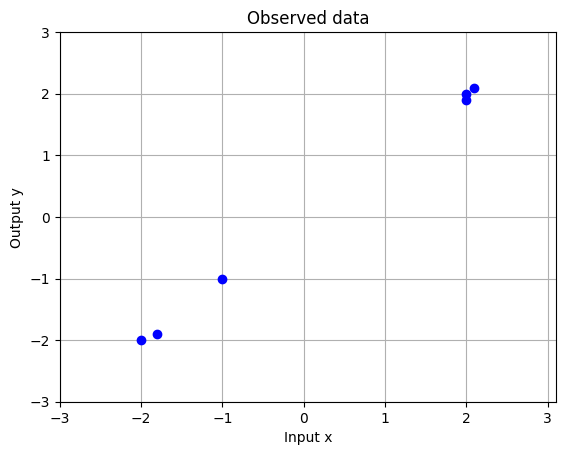

In [78]:
# @title Lets start with a very simple dataset, one that is very close to the indentity function


x_data_list_identity = jnp.array([-2, -1.8, -1, 2, 2, 2.1])
y_data_list_identity = jnp.array([-2, -1.9, -1, 2, 1.9, 2.1])

plot_basic_data(x_data_list_identity, y_data_list_identity, ylim=[-3, 3])

In [79]:
# @title Lets start with a very basic NN
# @markdown Specifically, a 1 hidden layer, & 1 hidden unit NN with no non-linearity:








# @markdown This model is linear in the inputs and weights.


def NN(x, params):
    return params[1] * params[0] * x


vmap_NN = jit(vmap(NN, in_axes=(0, None)))

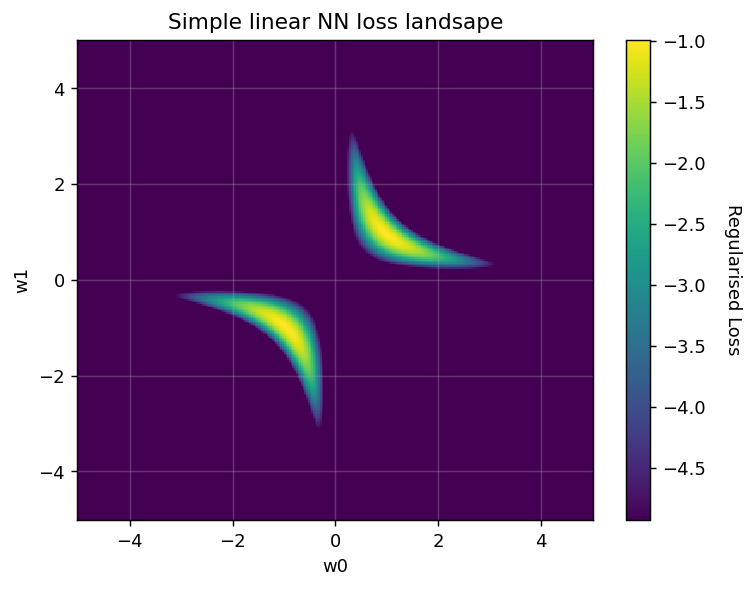

In [81]:
# @title ## Plot the loss landscape. It is non-convex. Its multimodal!
# @markdown Even though we are trying to learn a simple identity function with a linear NN.

# @markdown This is due to the symmetries in the weight space between
#You can flip these weights around and obtain the same solution!


alpha = 1


def generate_loss_fun():
    def loss_fun(w):
        return regularised_linear_regression_loss(
            X=x_data_list_identity,
            y=y_data_list_identity,
            w=w,
            vmap_model=vmap_NN,
            alpha=alpha,
        )

    return loss_fun


loss_fun = generate_loss_fun()

x0_grid, x1_grid, loss_grid = generate_loss_grid(
    loss_fun=loss_fun, grid_size=300, lim0=[-5, 5], lim1=[-5, 5]
)

fig = plt.figure(dpi=130)
loss_landscape = plt.pcolormesh(
    x0_grid,
    x1_grid,
    -loss_grid,
    vmin=-loss_grid.min() * 5,
    vmax=-loss_grid.min(),
    cmap="viridis",
)  #

plt.xlabel("w0")
plt.ylabel("w1")
ax = [plt.gca()]
cbar = fig.colorbar(loss_landscape, ax=ax[0])
cbar.set_label("Regularised Loss", rotation=270, labelpad=20)
plt.title("Simple linear NN loss landsape")
plt.grid(alpha=0.3)


**Our unimodal Gaussian approximation will struggle with the multimodal posterior but lets apply the black box variational inference algorithm anyway!**

In [82]:
# @title define plotting method -- run this cell but there is no need to look at the code


def gen_plots(params):
    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_mu = params["w"]

    fig, ax = plt.subplots(1, 2, dpi=160, figsize=(10, 4))

    loss_landscape = ax[0].pcolormesh(
        x0_grid,
        x1_grid,
        -loss_grid,
        vmin=-loss_grid.min() * 5,
        vmax=-loss_grid.min(),
        cmap="viridis",
    )  #
    plot_log_gaussian_ellipse(
        ax=ax[0],
        mean=q_mu,
        cov=q_covariance,
        color="cyan",
        alpha=1,
        lw=1,
        label="variational posterior",
        MAP_size=25,
        std_levels=[1, 2, 4, 6],
    )
    ax[0].set_ylabel("w")
    ax[0].set_xlabel("b")
    ax[0].grid(alpha=0.3)
    ax[0].legend()
    ax[0].set_ylim([-5, 5])
    ax[0].set_xlim([-5, 5])
    cbar = fig.colorbar(loss_landscape, ax=ax[0])
    cbar.set_label("Regularised Loss", rotation=270, labelpad=20)
    ax[0].set_title("variational distribution fit to true posterior")

    # Plot posterior predictive

    x_pred = np.linspace(-5, 5, 100)
    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(
        key, q_mu, q_covariance, shape=(Nsamples,)
    )
    q_sample_preds = vmap_NN(x_pred, q_parameter_samples.T)

    for i, sample in enumerate(q_sample_preds.T):
        if i == 0:
            ax[1].plot(
                x_pred,
                sample,
                "-",
                color="cyan",
                lw=0.4,
                alpha=1,
                label="sample predictions",
            )
        ax[1].plot(x_pred, sample, "-", color="cyan", lw=0.4, alpha=1)

    errorfill(
        x_pred,
        q_sample_preds.mean(axis=1),
        q_sample_preds.std(axis=1),
        color="cyan",
        alpha_fill=0.2,
        line_alpha=1,
        ax=ax[1],
        lw=2.5,
        linestyle="--",
        fill_linewidths=0.2,
        marker=None,
        markersize=1,
        label="preditive mean",
        markevery=None,
    )

    ax[1].plot(x_data_list_identity, y_data_list_identity, "ob")
    ax[1].set(xlabel="Input x", ylabel="Output y", xlim=[-3, 3], ylim=[-4, 4])
    ax[1].grid(alpha=0.3)
    ax[1].set_title("Predictive posterior fit")
    ax[1].legend()

    plt.tight_layout()

In [83]:
# @title **Plotting task** `Base` Try setting `large_init` to both true and false and optimising the variational parameters.
# @markdown What changes?

large_init = True  # @param ['True', 'False'] {type:"raw"}

Gaussian_ELBO = gen_Gaussian_ELBO(
    model=vmap_NN, alpha=alpha, ll_func=gaussian_ll, Nsamples=100
)


params = initialize_params(D=2, key=random.PRNGKey(42))
if large_init:
    params["w"] = params["w"] * 5


objective = jit(partial(Gaussian_ELBO, X=x_data_list_identity, y=y_data_list_identity))


optimise(
    objective,
    params=params,
    plotting_func=gen_plots,
    LR=5e-3,
    MAX_STEPS=2000,
    LOG_EVERY=50,
)

TypeError: ignored

Exploring the limitations of Variational Inference for BNNs

In [84]:
def NN(x, params):
    return params[2] * jax.nn.relu(x * params[0] + params[1]) + params[3]


vmap_NN = jit(vmap(NN, in_axes=(0, None)))

In [85]:
# @title plot generation code -- run this cell but there is no need to look at the code


def gen_plots(params):
    # Plot loss landscape and variational distribution
    q_covariance = get_Sig(params, min_diag=1e-6)
    q_MAP = params["w"]

    # Plot posterior predictive

    x_pred = np.linspace(-5, 5, 100)
    Nsamples = 20
    q_parameter_samples = jax.random.multivariate_normal(
        key, q_MAP, q_covariance, shape=(Nsamples,)
    )
    q_sample_preds = vmap_NN(x_pred, q_parameter_samples.T)

    plt.figure(dpi=120)

    ax = plt.gca()

    for i, sample in enumerate(q_sample_preds.T):
        if i == 0:
            ax.plot(
                x_pred,
                sample,
                "-",
                color="cyan",
                lw=0.4,
                alpha=1,
                label="sample predictions",
            )
        ax.plot(x_pred, sample, "-", color="cyan", lw=0.4, alpha=1)

    errorfill(
        x_pred,
        q_sample_preds.mean(axis=1),
        q_sample_preds.std(axis=1),
        color="cyan",
        alpha_fill=0.2,
        line_alpha=1,
        ax=ax,
        lw=2.5,
        linestyle="--",
        fill_linewidths=0.2,
        marker=None,
        markersize=1,
        label="preditive mean",
        markevery=None,
    )

    ax.plot(x_data_list_identity, x_data_list_identity, "ob")
    ax.set_title("Predictive posterior fit")
    ax.set(xlabel="Input x", ylabel="Output y", xlim=[-3, 3], ylim=[-4, 4])
    plt.grid(alpha=0.3)
    plt.legend()

In [86]:
# @title **Plotting task**  `Base`: Optimise the variational parameters with different seeds
# @markdown We cant plot the loss landscape anymore because it is 4 dimensional. But we can always plot the predictive posterior

# @markdown Try using different seeds: 0 and 42

alpha = 0.1

Gaussian_ELBO = gen_Gaussian_ELBO(
    model=vmap_NN, alpha=alpha, ll_func=gaussian_ll, Nsamples=100
)

Seed = 43  # @param {type:"integer"}

params = initialize_params(D=4, key=random.PRNGKey(Seed))


objective = jit(partial(Gaussian_ELBO, X=x_data_list_identity, y=y_data_list_identity))

optimise(
    objective,
    params=params,
    plotting_func=gen_plots,
    LR=2e-3,
    MAX_STEPS=3000,
    LOG_EVERY=50,
)

TypeError: ignored

**Hamiltonian Monte Carlo (Optional)**

In [87]:
# @title Here we define our numpyro model

# @markdown We specify a priors over our weights n with `numpyro.sample("w"...)` and the likelihood function `numpyro.sample(name="err"..., obs=err)`. The `obs` parameter states that we observe the targets, making this a likelihood funciton.

# @markdown Although HMC can work with the loss function directly, and numpyro supports this, it is more natural to specify our model in terms of prior and likelihood in numpyro.

import numpyro
from numpyro.infer import MCMC, NUTS, init_to_value
import numpyro.distributions as dist


def NN_numpyro_model(y, X, D, model, alpha):
    w = numpyro.sample("w", dist.Normal(jnp.zeros(D), (alpha**-0.5) * jnp.ones(D)))
    preds = model(X, w)
    err = y - preds
    numpyro.sample(name="err", fn=dist.Normal(0, jnp.ones(len(y))), obs=err)

In [88]:
# @title Code to draw samples -- We use a standard configuraition


def draw_samples(
    model, warmup, n_samples, thinning, num_chains, init_dict={}, max_tree_depth=12
):

    nuts_kernel = NUTS(
        model,
        forward_mode_differentiation=False,
        max_tree_depth=max_tree_depth,
        init_strategy=init_to_value(values=init_dict),
    )
    mcmc = MCMC(
        nuts_kernel,
        num_warmup=warmup,
        num_samples=n_samples,
        thinning=thinning,
        num_chains=num_chains,
    )
    rng_key = random.PRNGKey(0)

    mcmc.run(
        rng_key,
    )
    mcmc.print_summary()
    return mcmc.get_samples(group_by_chain=False)


alpha = 0.05

sampling_model = partial(
    NN_numpyro_model,
    y=y_data_list_identity,
    X=x_data_list_identity,
    D=4,
    model=vmap_NN,
    alpha=alpha,
)
samples = draw_samples(
    sampling_model, warmup=5000, n_samples=5000, thinning=10, num_chains=1
)


sample: 100%|██████████| 10000/10000 [00:07<00:00, 1355.67it/s, 63 steps of size 1.10e-01. acc. prob=0.42]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]     -1.75      2.07     -0.86     -4.55     -0.16     16.55      1.00
      w[1]      0.80      2.22      0.26     -1.73      4.68     27.61      1.00
      w[2]     -2.32      1.49     -3.11     -3.97     -0.21      5.14      1.00
      w[3]      1.92      0.99      1.75      0.87      2.98     90.88      1.00

Number of divergences: 65


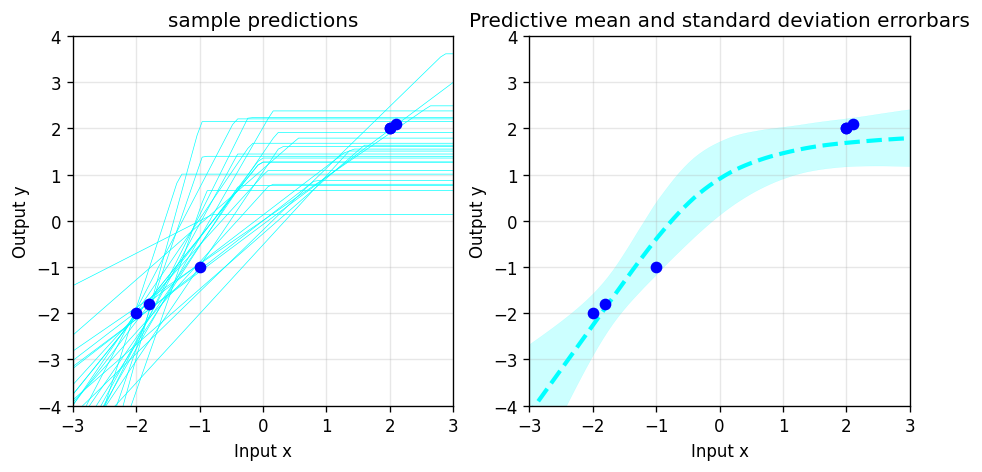

In [89]:
# @title Lets see the results

# @markdown We should get a much smoother regression line than with VI


sample_preds = vmap_NN(x_pred, samples["w"].T)

fig, ax = plt.subplots(1, 2, dpi=120, figsize=(9, 4))


for i, sample in enumerate(sample_preds.T[::20]):
    if i == 0:
        ax[0].plot(
            x_pred,
            sample,
            "-",
            color="cyan",
            lw=0.4,
            alpha=1,
            label="sample predictions",
        )
    ax[0].plot(x_pred, sample, "-", color="cyan", lw=0.4, alpha=1)


ax[0].plot(x_data_list_identity, x_data_list_identity, "ob")
ax[0].set_title("sample predictions")
ax[0].set(xlabel="Input x", ylabel="Output y", xlim=[-3, 3], ylim=[-4, 4])
ax[0].grid(alpha=0.3)

errorfill(
    x_pred,
    sample_preds.mean(axis=1),
    sample_preds.std(axis=1),
    color="cyan",
    alpha_fill=0.2,
    line_alpha=1,
    ax=ax[1],
    lw=2.5,
    linestyle="--",
    fill_linewidths=0.2,
    marker=None,
    markersize=1,
    label="preditive mean",
    markevery=None,
)


ax[1].plot(x_data_list_identity, x_data_list_identity, "ob")
ax[1].set_title("Predictive mean and standard deviation errorbars")
ax[1].set(xlabel="Input x", ylabel="Output y", xlim=[-3, 3], ylim=[-4, 4])
ax[1].grid(alpha=0.3)
# plt.legend()